In [ ]:
!pip install -q pmdarima
! pip install --upgrade Cython
! pip install --upgrade git+https://github.com/statsmodels/statsmodels


     |████████████████████████████████| 6.3MB 8.6MB/s 
     |████████████████████████████████| 1.5MB 6.8MB/s 
     |████████████████████████████████| 9.5MB 23.8MB/s 
Requirement already up-to-date: Cython in /usr/local/lib/python3.7/dist-packages (0.29.23)
  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-965aay_v
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-965aay_v
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.13.0.dev0+367.gc2d87b6ec-cp37-cp37m-linux_x86_64.whl size=17617972 sha256=bdd1290799c2fc735506fed7912a3416d447f4eac167b1237e47ef312c738d1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-xncfs65u/wheels/7d/ad/45/ac1a03bd759c2fa74c486e2b1950d94b55f511b4c2b0418bd5
Successfully built statsmodels
  Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-

In [1]:
!pip install -q yfinance


In [2]:

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import plotly.express as px
from statsmodels.tsa.arima_model import ARIMA
import yfinance as yf
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import itertools

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace import sarimax

from dateutil.relativedelta import relativedelta




In [3]:
banco = yf.Ticker("BAMI.MI")

In [4]:

hist = banco.history(period='max')
hist['Daily Return'] = np.log(hist['Close'] / hist['Close'].shift(1))
hist = hist.loc['1999-01-01':]
hist.reset_index(inplace = True)
# hist = hist.set_index('Date')
# print(hist.head())
print(hist)

           Date       Open       High  ...  Dividends  Stock Splits  Daily Return
0    2000-01-03  66.776240  69.215813  ...        0.0           0.0           NaN
1    2000-01-04  68.081120  68.081120  ...        0.0           0.0     -0.023650
2    2000-01-05  65.811750  65.811750  ...        0.0           0.0     -0.026853
3    2000-01-06  64.960727  64.960727  ...        0.0           0.0      0.004380
4    2000-01-07  65.301144  67.230110  ...        0.0           0.0      0.021618
...         ...        ...        ...  ...        ...           ...           ...
5475 2021-06-07   3.000000   3.069000  ...        0.0           0.0      0.014913
5476 2021-06-08   3.069000   3.093000  ...        0.0           0.0     -0.005608
5477 2021-06-09   3.018000   3.067000  ...        0.0           0.0      0.003632
5478 2021-06-10   3.035000   3.062000  ...        0.0           0.0     -0.001979
5479 2021-06-11   3.014000   3.034000  ...        0.0           0.0      0.000330

[5480 rows x 9 

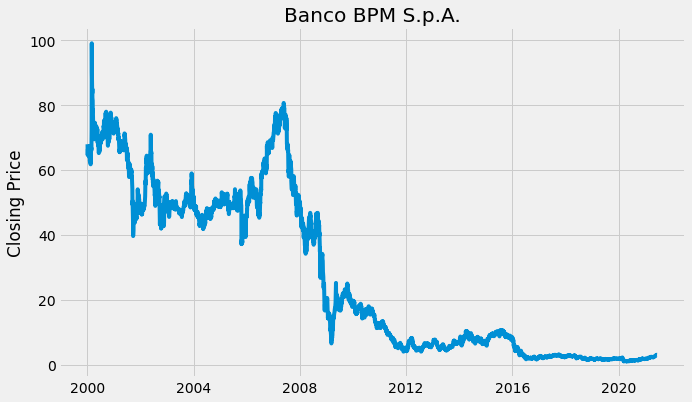

In [5]:
hist2=hist
hist2.index=hist2.Date
plt.title('Banco BPM S.p.A.')
plt.ylabel('Closing Price')
close = plt.plot(hist2['Close'])

In [6]:
import pandas as pd
import statsmodels.api as sm

Manual Stationarity

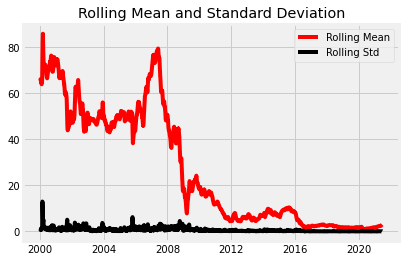

Results of dickey fuller test
Test Statistics                  -1.280721
p-value                           0.637946
No. of lags used                 24.000000
Number of observations used    5455.000000
critical value (1%)              -3.431549
critical value (5%)              -2.862070
critical value (10%)             -2.567052
dtype: float64


In [ ]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    #plt.plot(timeseries , color='blue',label='Original')
    
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
   
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(hist['Close'])

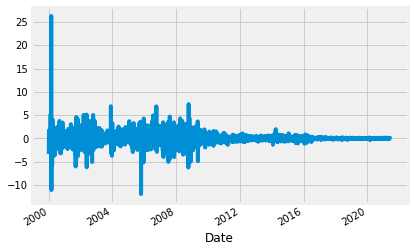

In [ ]:
hist['Close1'] = hist['Close'] - hist['Close'].shift(2)
hist['Close1'].dropna().plot()


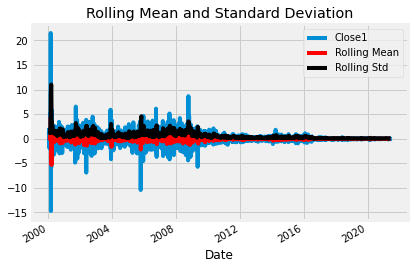

Results of dickey fuller test
Test Statistics                 -22.068909
p-value                           0.000000
No. of lags used                 33.000000
Number of observations used    5433.000000
critical value (1%)              -3.431554
critical value (5%)              -2.862072
critical value (10%)             -2.567053
dtype: float64


In [ ]:
rolling_mean = hist['Close1'].rolling(window=12).mean()
df_log_minus_mean = hist['Close1'] - rolling_mean
df_log_minus_mean.dropna().plot()

df_log_minus_mean.dropna(inplace=True)
test_stationarity(df_log_minus_mean)

<Figure size 432x288 with 0 Axes>

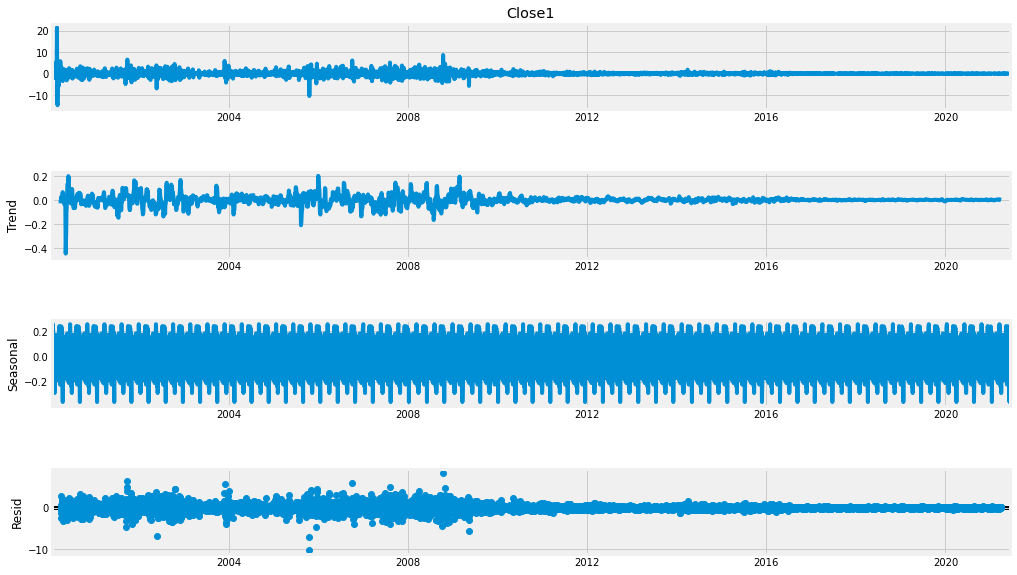

In [ ]:
result = seasonal_decompose(df_log_minus_mean, freq = 100)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

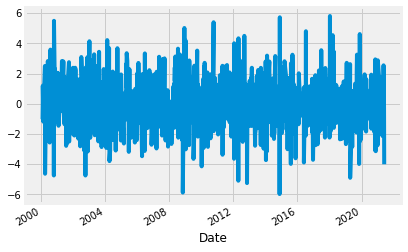

In [ ]:
df1=df_log_minus_mean
d=df1.values
fl = df1.astype(str).astype(float)
l2 = np.log(fl)
l1 = l2 - l2.shift(3)
l1.dropna().plot()

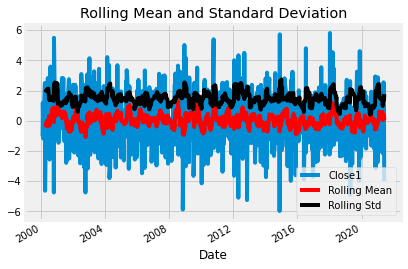

Results of dickey fuller test
Test Statistics                 -28.853589
p-value                           0.000000
No. of lags used                  1.000000
Number of observations used    1240.000000
critical value (1%)              -3.435635
critical value (5%)              -2.863874
critical value (10%)             -2.568012
dtype: float64


In [ ]:
 
l1.dropna().plot()

l1.dropna(inplace=True)
test_stationarity(l1)

SARIMA with non stationary series

In [ ]:

p = q = range(0, 3)
d = range(1,3)
s = 12

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], s) for x in list(itertools.product(p,d,q))]


In [ ]:
ans = []
best_terms = (0,0)
best_aic = 99999 ### arbitrary number to replace
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sarimax.SARIMAX(hist['Close'].values,
                                  order=comb,
                                  seasonal_order=combs,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            if output.aic < best_aic:
                best_aic = output.aic
                best_terms = (comb, combs)
        except:
            continue
        print(f'SARIMA {comb} x {combs} : AIC Calculated = {output.aic}')

SARIMA (0, 1, 0) x (0, 1, 0, 12) : AIC Calculated = 15890.3681822927
SARIMA (0, 1, 0) x (0, 1, 1, 12) : AIC Calculated = 12031.574286407202
SARIMA (0, 1, 0) x (0, 1, 2, 12) : AIC Calculated = 11970.305336354902
SARIMA (0, 1, 0) x (0, 2, 0, 12) : AIC Calculated = 21785.635306373137
SARIMA (0, 1, 0) x (0, 2, 1, 12) : AIC Calculated = 15856.72947902725
SARIMA (0, 1, 0) x (0, 2, 2, 12) : AIC Calculated = 11732.921584126452
SARIMA (0, 1, 0) x (1, 1, 0, 12) : AIC Calculated = 14414.163466389873
SARIMA (0, 1, 0) x (1, 1, 1, 12) : AIC Calculated = 12037.15948291776
SARIMA (0, 1, 0) x (1, 1, 2, 12) : AIC Calculated = 11861.489492374167
SARIMA (0, 1, 0) x (1, 2, 0, 12) : AIC Calculated = 18777.465542402802
SARIMA (0, 1, 0) x (1, 2, 1, 12) : AIC Calculated = 14459.058977752633
SARIMA (0, 1, 0) x (1, 2, 2, 12) : AIC Calculated = 11737.174279204854
SARIMA (0, 1, 0) x (2, 1, 0, 12) : AIC Calculated = 13563.546244867746
SARIMA (0, 1, 0) x (2, 1, 1, 12) : AIC Calculated = 11982.36405510484
SARIMA (0, 

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA (0, 1, 0) x (2, 2, 0, 12) : AIC Calculated = 16610.811960287625
SARIMA (0, 1, 0) x (2, 2, 1, 12) : AIC Calculated = 13620.889241131248
SARIMA (0, 1, 0) x (2, 2, 2, 12) : AIC Calculated = 12135.15664148943
SARIMA (0, 1, 1) x (0, 1, 0, 12) : AIC Calculated = 15833.208045495394
SARIMA (0, 1, 1) x (0, 1, 1, 12) : AIC Calculated = 11979.80529509429
SARIMA (0, 1, 1) x (0, 1, 2, 12) : AIC Calculated = 11912.379936164181
SARIMA (0, 1, 1) x (0, 2, 0, 12) : AIC Calculated = 21729.377173903584
SARIMA (0, 1, 1) x (0, 2, 1, 12) : AIC Calculated = 15793.909342027597
SARIMA (0, 1, 1) x (0, 2, 2, 12) : AIC Calculated = 11708.279391242268
SARIMA (0, 1, 1) x (1, 1, 0, 12) : AIC Calculated = 14357.395693394019
SARIMA (0, 1, 1) x (1, 1, 1, 12) : AIC Calculated = 11982.767510741893
SARIMA (0, 1, 1) x (1, 1, 2, 12) : AIC Calculated = 11827.133868796416
SARIMA (0, 1, 1) x (1, 2, 0, 12) : AIC Calculated = 18715.239048326963
SARIMA (0, 1, 1) x (1, 2, 1, 12) : AIC Calculated = 14399.747963469405
SARIMA (

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA (0, 1, 1) x (2, 2, 2, 12) : AIC Calculated = 12079.351592928386
SARIMA (0, 1, 2) x (0, 1, 0, 12) : AIC Calculated = 15830.411542196036
SARIMA (0, 1, 2) x (0, 1, 1, 12) : AIC Calculated = 11978.811954391975
SARIMA (0, 1, 2) x (0, 1, 2, 12) : AIC Calculated = 11913.090307547862
SARIMA (0, 1, 2) x (0, 2, 0, 12) : AIC Calculated = 21723.999258528755
SARIMA (0, 1, 2) x (0, 2, 1, 12) : AIC Calculated = 15793.212383901127
SARIMA (0, 1, 2) x (0, 2, 2, 12) : AIC Calculated = 11704.05444071642
SARIMA (0, 1, 2) x (1, 1, 0, 12) : AIC Calculated = 14359.131631740742
SARIMA (0, 1, 2) x (1, 1, 1, 12) : AIC Calculated = 11981.370866796427
SARIMA (0, 1, 2) x (1, 1, 2, 12) : AIC Calculated = 11827.765584196979
SARIMA (0, 1, 2) x (1, 2, 0, 12) : AIC Calculated = 18717.13901251874
SARIMA (0, 1, 2) x (1, 2, 1, 12) : AIC Calculated = 14398.934848868048
SARIMA (0, 1, 2) x (1, 2, 2, 12) : AIC Calculated = 11706.79937508634
SARIMA (0, 1, 2) x (2, 1, 0, 12) : AIC Calculated = 13509.916290347968
SARIMA (0

In [7]:
l1=hist['Close']

#selected model by AIC on bias variance trade off SARIMA (0, 1, 0) x (0, 2, 2, 12) : AIC Calculated = 11732.921584126452


In [10]:
model = sarimax.SARIMAX(l1, 
                        order=(0,1,0), 
                        seasonal_order = (0, 2, 2, 12), 
                        enforce_stationarity=False,
                        enforce_invertibility=False)
res = model.fit()
res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 5480
Model:             SARIMAX(0, 1, 0)x(0, 2, 2, 12)   Log Likelihood               -5863.461
Date:                            Sat, 12 Jun 2021   AIC                          11732.922
Time:                                    14:27:20   BIC                          11752.721
Sample:                                         0   HQIC                         11739.832
                                           - 5480                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -1.9860      0.007   -278.501      0.000      -2.000      -1.972
ma.S.L24       0.9861      0.007    140.412      0.000       0.972       1.000
sigma2         0.4935      0.004    116.327      0.000       0.485       0.502
===================================================================================
Ljung-Box (Q):                      174.57   Jarque-Bera (JB):            164868.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Results

In [30]:
start = datetime.datetime.strptime("2020-03-31", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list)
dfm_full = pd.concat([l1, future])

[]

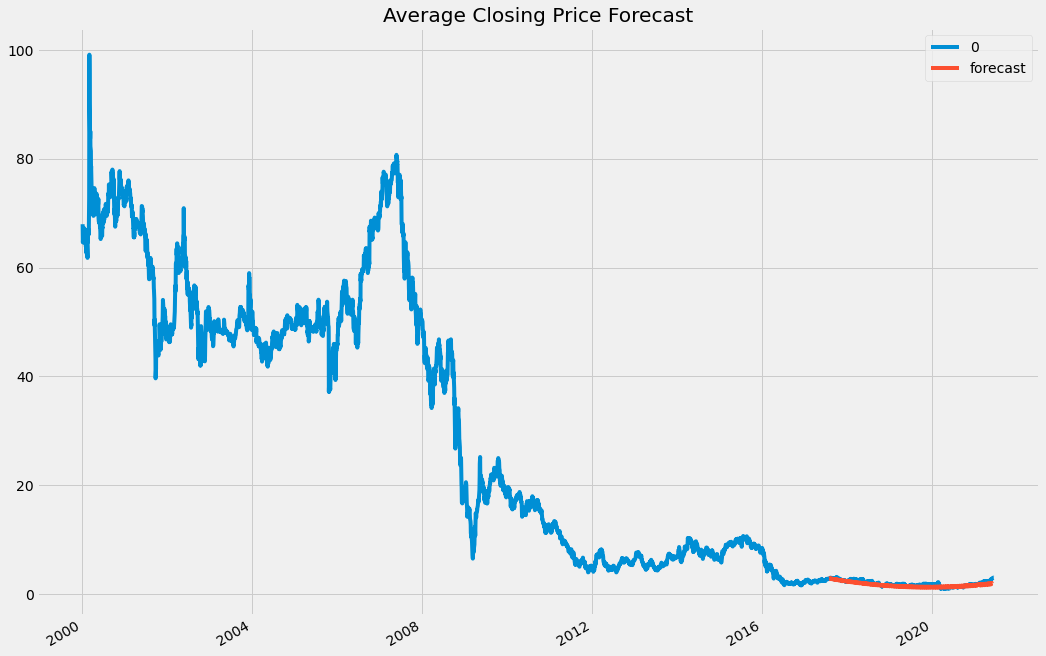

In [86]:

dfm_full['forecast'] = res.predict(start=4500, end= 5470, dynamic= True) 

dfm_full[[0, 'forecast']].plot(figsize=(16, 12), title='Average Closing Price Forecast'); 

plt.plot(x_label='year')

Forecast

In [87]:
forecast=res.predict(start = len(dfm_full),end=len(dfm_full)+1000, typ='levels')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Timestamp('2021-06-11 00:00:00')

In [93]:
idx = pd.date_range(max(dfm_full.index),max(dfm_full.index) + pd.DateOffset(days=1000))

In [94]:
forecast.index=idx

In [98]:
ff=dfm_full[0].append(forecast)

[]

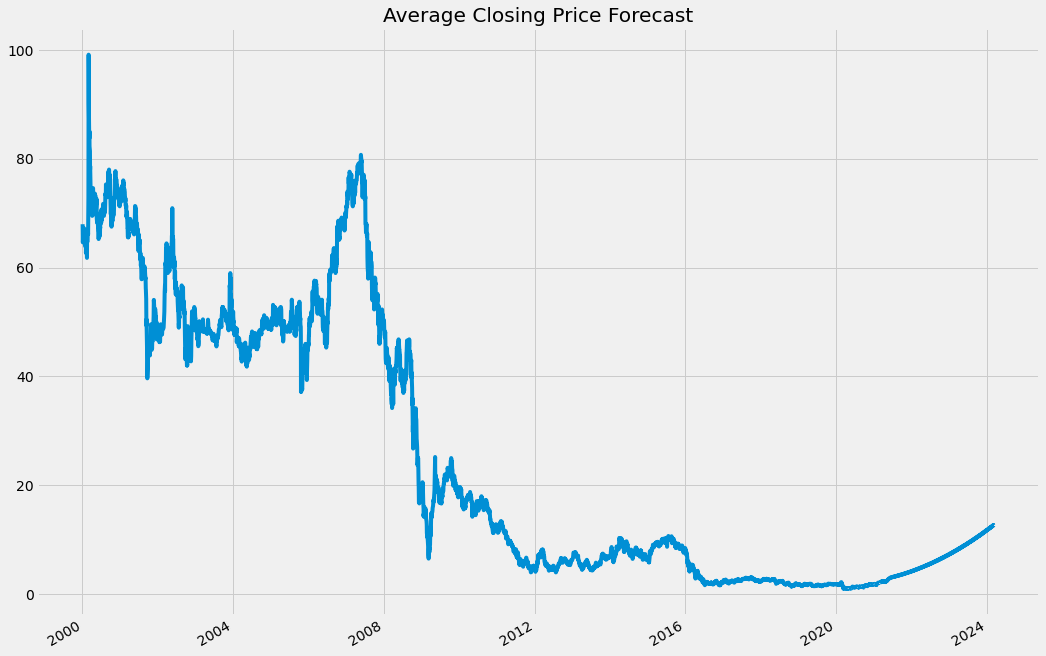

In [99]:
start = datetime.datetime.strptime("2020-03-31", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list)
dfm_full = pd.concat([l1, future])                           
ff.plot(figsize=(16, 12), title='Average Closing Price Forecast'); 
plt.plot(x_label='year')

In [108]:
mse = mean_squared_error(hist['Close'].values[4500:5471], res.predict(start=4500, end= 5470, dynamic= True) )
print('MSE: '+str(mse))


MSE: 0.1344988881704154


In [109]:
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.366741
